Comparing Team 1: 'Stony Brook Womens Soccer' and Team 2: 'Stony Brook Football'.
DataFrame 'df' populated with data for selected teams and metrics.
    playername                             team                 metric  \
0   PLAYER_425  Team: Stony Brook Womens Soccer  Avg. Braking Force(N)   
1   PLAYER_231  Team: Stony Brook Womens Soccer  Avg. Braking Force(N)   
2   PLAYER_059  Team: Stony Brook Womens Soccer  Avg. Braking Force(N)   
3   PLAYER_106  Team: Stony Brook Womens Soccer  Avg. Braking Force(N)   
4  PLAYER_1156  Team: Stony Brook Womens Soccer  Avg. Braking Force(N)   

      value           timestamp  
0  900.2957 2019-08-06 10:50:21  
1  897.8224 2019-08-06 10:50:44  
2  974.3384 2019-08-06 10:51:00  
3  843.2964 2019-08-06 10:51:16  
4  887.4198 2019-08-06 10:51:30  


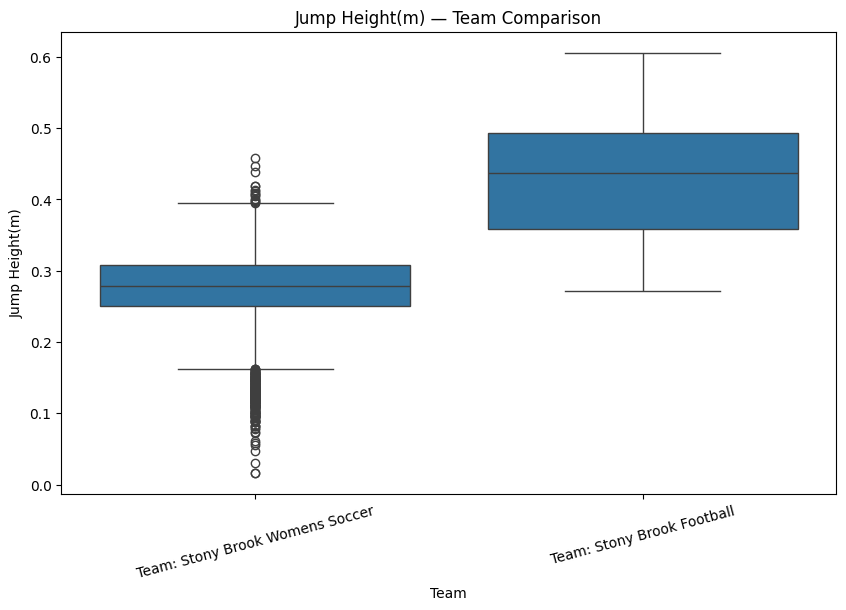

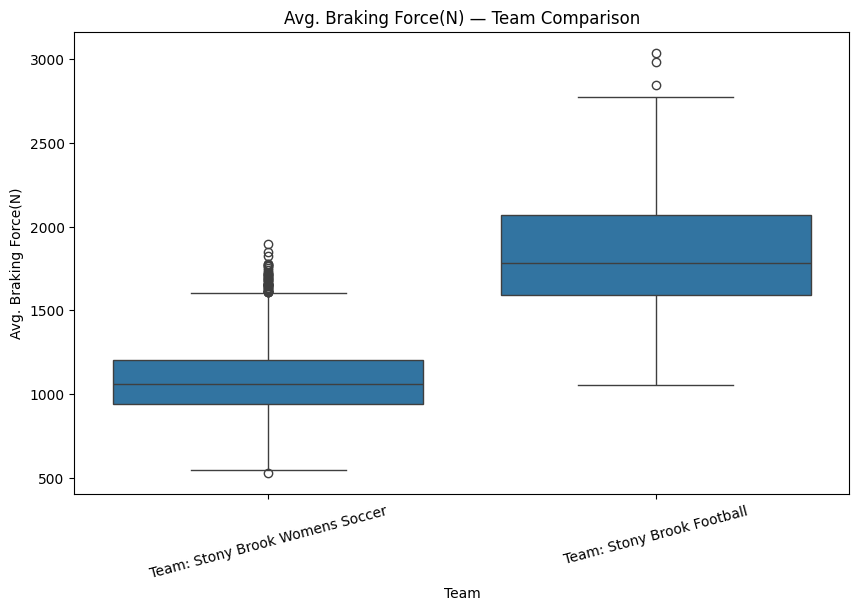

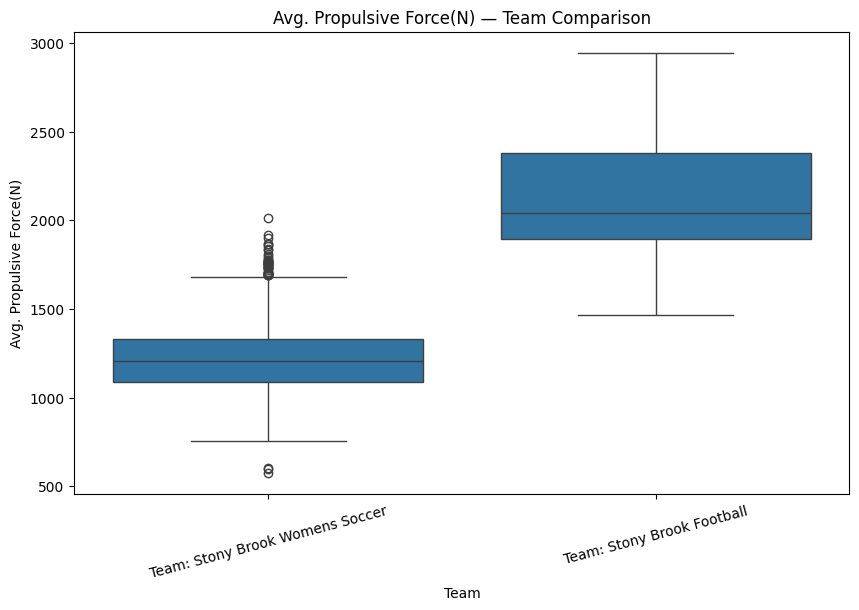

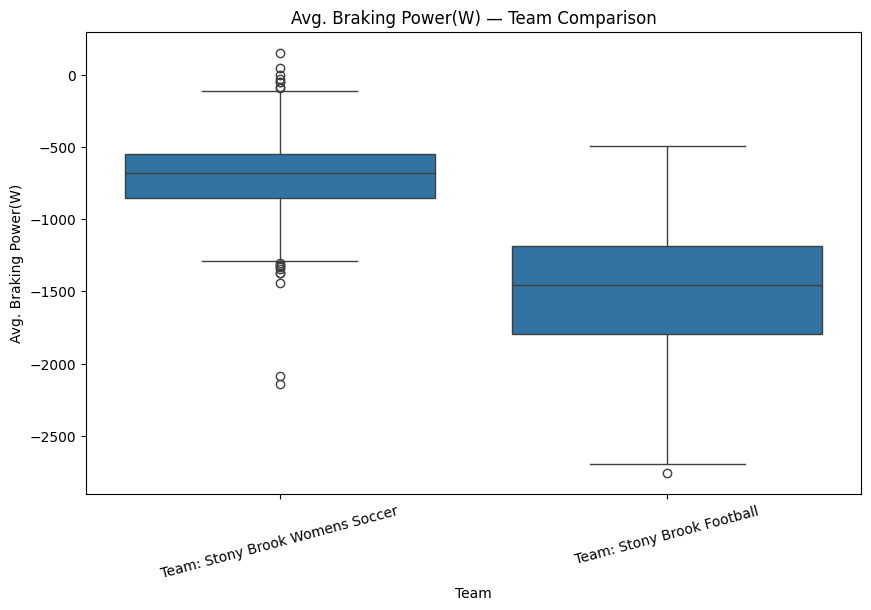

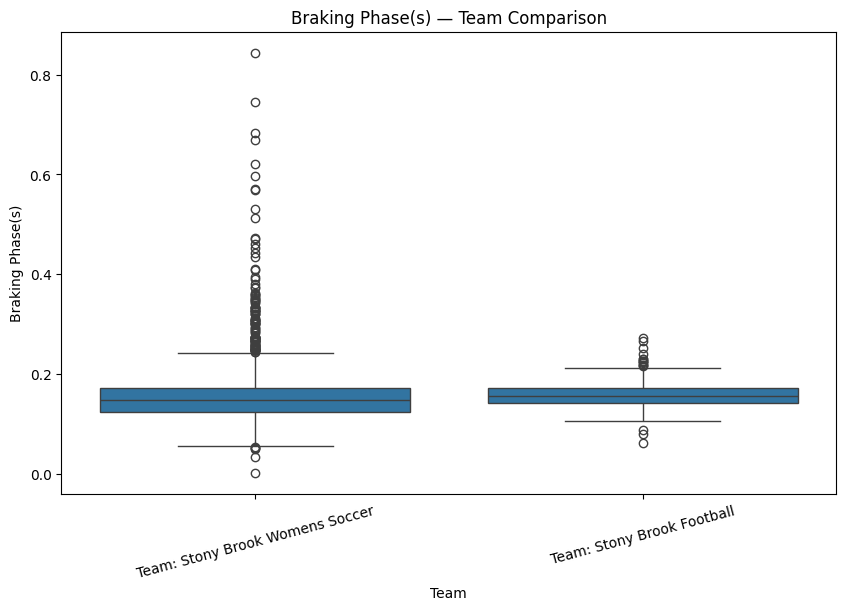

In [12]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import sqlalchemy
from sqlalchemy import create_engine, text
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats 
from sqlalchemy.exc import OperationalError, ProgrammingError 
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
from IPython.display import display



load_dotenv('test.env')
load_dotenv('test.env', override=True)

sql_username = os.getenv('DB_USER')
sql_password = os.getenv('DB_PASSWORD')
sql_host = os.getenv('DB_HOST')
sql_database = os.getenv('DB_NAME')

sql_username

# with SSL off

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"

conn = create_engine(url_string)


selected_metrics = [
    'Jump Height(m)',
    'Avg. Braking Force(N)',
    'Avg. Propulsive Force(N)',
    'Avg. Braking Power(W)',
    'Braking Phase(s)'
]

# Step 1: Get distinct team names from the database
try:
    distinct_teams_query = "SELECT DISTINCT team FROM research_experiment_refactor_test WHERE team IS NOT NULL;"
    distinct_teams_df = pd.read_sql(distinct_teams_query, conn)
    distinct_teams = distinct_teams_df["team"].tolist()
    distinct_teams = [team for team in distinct_teams if team != ''] # Filter out empty strings if any
except Exception as e:
    print(f"Error fetching distinct team names: {e}")
    distinct_teams = []

# Step 2: Select two different teams for comparison based on availability
team1 = 'Stony Brook Womens Soccer'
team2 = 'Stony Brook Football'
teams_to_query = []

# Prioritize specific teams known to have data for these metrics
# from previous successful queries (e.g., PLAYER_078 and PLAYER_084 were in 'Team: Stony Brook Womens Soccer')
preferred_team_candidates = ["Team: Stony Brook Womens Soccer", "Team: Stony Brook Football"]

for candidate_team in preferred_team_candidates:
    if candidate_team in distinct_teams and candidate_team not in teams_to_query:
        if team1 is None:
            team1 = candidate_team
        elif team2 is None:
            team2 = candidate_team
        teams_to_query.append(candidate_team)
        if len(teams_to_query) == 2:
            break

# If we still need more teams, pick from the remaining distinct_teams list
if len(teams_to_query) < 2:
    for d_team_name in distinct_teams:
        if d_team_name not in teams_to_query:
            if team1 is None:
                team1 = d_team_name
            elif team2 is None:
                team2 = d_team_name
            teams_to_query.append(d_team_name)
            if len(teams_to_query) == 2:
                break

if len(teams_to_query) >= 2:
    print(f"Comparing Team 1: '{team1}' and Team 2: '{team2}'.")
elif len(teams_to_query) == 1:
    print(f"Only one distinct team found: '{team1}'. Cannot perform a two-team comparison.")
    print(f"Proceeding with data for '{team1}' only.")
else:
    print("No distinct teams found in the database. Cannot perform any team comparison.")
    df = pd.DataFrame() # Ensure df is empty

if teams_to_query:
    # Construct the query based on the selected teams
    teams_in_clause = ','.join([f"'{t}'" for t in teams_to_query])
    metrics_in_clause = ','.join([f"'{m}'" for m in selected_metrics])

    query = f"""
    SELECT playername, team, metric, value, timestamp
    FROM research_experiment_refactor_test
    WHERE team IN ({teams_in_clause})
    AND metric IN ({metrics_in_clause})
    """
    df = pd.read_sql(query, conn)
    print("DataFrame 'df' populated with data for selected teams and metrics.")
    print(df.head())
else:
    print("Skipping data retrieval as no teams were selected.")
    df = pd.DataFrame()


if df.empty:
    print("No data found for the selected teams and metrics. Please check team names and metrics or database connectivity.")
else:
    for metric in selected_metrics:
        # Check if the metric exists in the filtered DataFrame before plotting
        metric_data = df[df["metric"] == metric]
        if not metric_data.empty:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=metric_data,
                        x="team", y="value")
            plt.title(f"{metric} \u2014 Team Comparison")
            plt.xlabel("Team")
            plt.ylabel(metric)
            plt.xticks(rotation=15)
            plt.show()
        else:
            print(f"Skipping plot for metric '{metric}' as no data was found for it in the selected teams.")




In [11]:


selected_metrics = [
    'Jump Height(m)',
    'Avg. Braking Force(N)',
    'Avg. Propulsive Force(N)',
    'Avg. Braking Power(W)',
    'Braking Phase(s)'
]


team1 = 'Stony Brook Womens Soccer'
team2 = 'Stony Brook Football'



# selected_metrics are also defined in the kernel

if team1 is None or team2 is None:
    print("Cannot perform statistical tests as two teams were not selected or found.")
else:
    for metric in selected_metrics:
        team1_vals = df[(df["team"] == team1) & (df["metric"] == metric)]["value"]
        team2_vals = df[(df["team"] == team2) & (df["metric"] == metric)]["value"]

        # Skip if missing data for either team for the current metric
        if len(team1_vals) < 2 or len(team2_vals) < 2:
            print(f"Skipping t-test for '{metric}' due to insufficient data for one or both teams.")
            continue

        tstat, pval = ttest_ind(team1_vals, team2_vals, equal_var=False)

        stats_results.append({
            "metric": metric,
            f"{team1}_mean": team1_vals.mean(), # Use team names dynamically
            f"{team2}_mean": team2_vals.mean(), # Use team names dynamically
            "t-statistic": tstat,
            "p-value": pval
        })

    # Only create and display DataFrame if there are results
    if stats_results:
        display(pd.DataFrame(stats_results))
    else:
        print("No statistical test results were generated.")

Skipping t-test for 'Jump Height(m)' due to insufficient data for one or both teams.
Skipping t-test for 'Avg. Braking Force(N)' due to insufficient data for one or both teams.
Skipping t-test for 'Avg. Propulsive Force(N)' due to insufficient data for one or both teams.
Skipping t-test for 'Avg. Braking Power(W)' due to insufficient data for one or both teams.
Skipping t-test for 'Braking Phase(s)' due to insufficient data for one or both teams.
No statistical test results were generated.


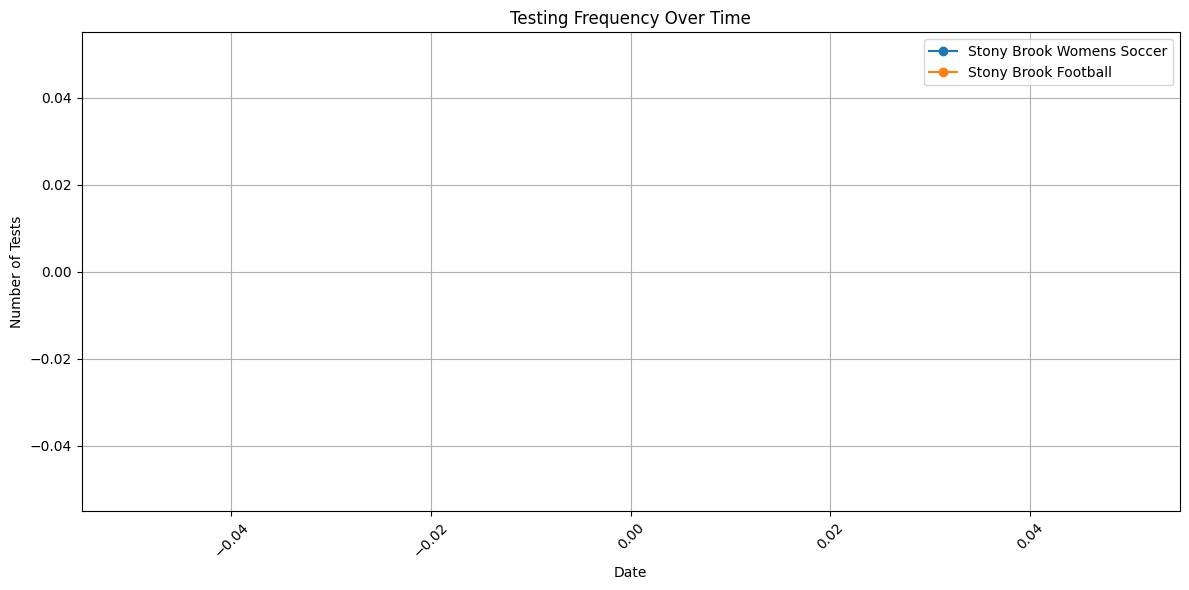

In [3]:
df["date"] = pd.to_datetime(df["timestamp"]).dt.date

freq = df.groupby(["date", "team"]).size().reset_index(name="tests")

plt.figure(figsize=(12,6))
for t in [team1, team2]:
    sub = freq[freq["team"] == t]
    plt.plot(sub["date"], sub["tests"], marker="o", label=t)

plt.title("Testing Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tests")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()